<a href="https://colab.research.google.com/github/GuilhermeDeAssis123/DataScience/blob/master/Projeto_de_Churn_Prediction_para_uma_empresa_de_Telecomunica%C3%A7%C3%B5es.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Churn Prediction

*Churn rate*, ou simplesmente *churn*, representa a taxa de evasão da sua base de clientes. Em serviços como Spotify ou Netflix, ela representaria a taxa de cancelamento de assinaturas.

<p align=center>
<img src="https://raw.githubusercontent.com/carlosfab/dsnp2/master/img/churnrate.jpg" width="60%"></p>

Ela é de extrema importância para a administração e sua análise ao longo do tempo pode mostrar que existe algum problema que deve ser atacado.

*Churn* também pode ser usado para identificar potenciais cancelamentos, com um tempo de antecedência, e promover ações direcionadas para tentar reter tais clientes. Essa métrica deve receber atenção pelo fato de que o Custo de Aquisição de Cliente (CAC) é normalmente mais alto que o custo para mantê-los. Ou seja, um alto valor para o *churn rate* é o que não desejamos.

## Aquisição dos Dados

Os dados utilizados neste projeto foram originalmente disponibilizados na [plataforma de ensino da IBM Developer](https://developer.ibm.com/technologies/data-science/patterns/predict-customer-churn-using-watson-studio-and-jupyter-notebooks/#), e tratam de um problema típico de uma companhia de telecomunicações. O *dataset* completo pode ser encontrado [neste link](https://raw.githubusercontent.com/carlosfab/dsnp2/master/datasets/WA_Fn-UseC_-Telco-Customer-Churn.csv).

Apesar de não haver informações explícitas disponíves, os nomes das colunas permitem um entendimento a respeito do problema.

In [ ]:
# instalar Pandas Profiling
!pip install scikit-plot -q
!pip install imbalanced-learn -q

In [ ]:
# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

# importar os pacotes necessários
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, confusion_matrix, classification_report
from scikitplot.metrics import plot_confusion_matrix, plot_roc
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from lightgbm import LGBMClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

# random seed
np.random.seed(42)

# importar os dados
DATA_PATH = "https://raw.githubusercontent.com/carlosfab/dsnp2/master/datasets/WA_Fn-UseC_-Telco-Customer-Churn.csv"
df = pd.read_csv(DATA_PATH)

# ver as 5 primeiras entradas
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


> Mostrando as 5 primeiras entradas do *dataset* podemos ter uma noção de como as informações estão dispostas. Apesar de não termos um dicionario de *features* podemos inferir do que se tratam as colunas, uma vez que as empresas de telecomunicações são parecidas.

> Vamos verificar a quantidade de informações que temos:

In [ ]:
print('Número de linhas: {}'.format(df.shape[0]))
print('Número de colunas: {}'.format(df.shape[1]))

Número de linhas: 7043
Número de colunas: 21


> Podemos ver que o nosso conjunto de dados é composto por 7043 linhas de entrada por 22 colunas de variáeis.

### Análise Exploratória

> Nesta estapa iremos realizar um pente fino nos dados a fim de conhecer melhor as informações com que estamos lidando, o principal objetivo nesta etapa é conhecer os dados e encontrar possíveis ruidos de informção que possam comprometer a nossa análise, além de levantar algumas hipóteses.

> O nosso primeiro passo é verificar a integridade dos nossos dados, para isso vamos ver a porção de informação ausente que temos em cada uma das colunas:

In [ ]:
(df.isnull().sum()/df.shape[0]).sort_values(ascending=False)


Churn               0.0
OnlineSecurity      0.0
gender              0.0
SeniorCitizen       0.0
Partner             0.0
Dependents          0.0
tenure              0.0
PhoneService        0.0
MultipleLines       0.0
InternetService     0.0
OnlineBackup        0.0
TotalCharges        0.0
DeviceProtection    0.0
TechSupport         0.0
StreamingTV         0.0
StreamingMovies     0.0
Contract            0.0
PaperlessBilling    0.0
PaymentMethod       0.0
MonthlyCharges      0.0
customerID          0.0
dtype: float64

> Pode-se observar que não existem informações ausentes, do tipo `NaN`, isso nos indica que não será necessário nenhum tipo de preenchimento de dados. Vamos olhar agora quais são os tipos de cada coluna, e verificar se existe alguma coluna que está com tipo incorreto.

In [ ]:
df.dtypes

customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

> Observe que a coluna `TotalCharges` apresenta valores do tipo **flutuante**, porém está classificada como **Object**, dessa forma teremos que ajustar o tipo dessa coluna. As demais colunas estão em seus devidos tipos, temos então pós mudança:

* 17 colunas do tipo String
* 2 colunas do tipo float
* 2 colunas do tipo int

> Vamos agora ver os valores únicos por coluna:

In [ ]:
df.nunique()

customerID          7043
gender                 2
SeniorCitizen          2
Partner                2
Dependents             2
tenure                73
PhoneService           2
MultipleLines          3
InternetService        3
OnlineSecurity         3
OnlineBackup           3
DeviceProtection       3
TechSupport            3
StreamingTV            3
StreamingMovies        3
Contract               3
PaperlessBilling       2
PaymentMethod          4
MonthlyCharges      1585
TotalCharges        6531
Churn                  2
dtype: int64

> Pontos interessantes a se observar:
* A coluna **costumerID** serve somente para identificar cada entrada, de forma que não agrega valor a nossa análise, assim ela sera excluída logo a frente.
* Existem muitas variáveis que posteriormente devem ser convertidas em **INT** para facilitar a análise e compreensão do modelo. 
* A nossa variável **alvo** é a coluna **churn**.




In [ ]:
#df["TotalCharges"].astype('float32')

> No momento de transformar a coluna `TotalCharges` em **float**, obteve-se um erro, mostrando que uma ou mais strings não puderam ser convertidas, logo, essas não são números. Vamos verificar as linhas para ver do que se trata.

In [ ]:
# Mostrar todas as linhas.
pd.set_option('display.max_rows', df.shape[0]+1)

In [ ]:
 """
    Converte um objeto do tipo string em float.

    # Arguments
        entrada: string, string da coluna TotalCharges.

    # Returns
        Valor convertido em float, caso permita a conversão.
        NaN, caso o valor não seja apropriado.
    """


def converter_str_float(entrada):
   
    try:
        return float(entrada)
    except ValueError:
        return np.nan

# criar cópia do dataframe
df_clean = df.copy()

# remover coluna costumerID
df_clean.drop("customerID", axis=1, inplace=True)

# converter as strings de TotalCharges para float
df_clean["TotalCharges"] = df_clean["TotalCharges"].apply(converter_str_float)

# verificar entradas ausentes
print("Dados ausentes em 'TotalCharges' (antes):\t{}\n".format(df_clean["TotalCharges"].isnull().sum()))

# substituir os dados ausentes pelo valor da mediana
TotalChargesMedian = df_clean.TotalCharges.median()
df_clean["TotalCharges"].fillna(TotalChargesMedian, inplace=True)

Dados ausentes em 'TotalCharges' (antes):	11



> Pode-se observar que 11 das entradas estavam com valores nulos.

> Vamos agora observar o resumo estatístico dos nossos dado, com o intuito de verificar a existência de outliers:

In [ ]:
df_clean.describe()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges
count,7043.000000,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692,2281.916928
std,0.368612,24.559481,30.090047,2265.270398
min,0.000000,0.000000,18.250000,18.800000
25%,0.000000,9.000000,35.500000,402.225000
50%,0.000000,29.000000,70.350000,1397.475000
75%,0.000000,55.000000,89.850000,3786.600000
max,1.000000,72.000000,118.750000,8684.800000


> Aparentemente não possuimos outliers, vamos plotar os boxplots das variáveis para verificar a hipótese.

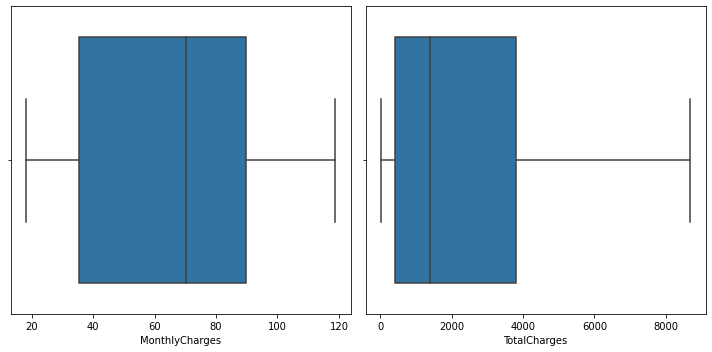

In [ ]:
fig, ax = plt.subplots(nrows = 1, ncols= 2, figsize=(10,5))
sns.boxplot(df_clean['MonthlyCharges'],ax=ax[0])
sns.boxplot(df_clean['TotalCharges'],ax=ax[1])
plt.tight_layout()


> Como podemos observar não existem pontos antes do primeiro quartíl, e nem depois do quarto quartíl. Dessa maneira não presença de outliers.

> Vamos agora observar a coluna `tenure`. Pelo que tudo indica essa *feature* diz respeito a quantidade de tempo que o cliente está com a empresa.

>Apesar de não haver nenhuma documentação, assumo que a unidade de tempo utilizada é "mês".

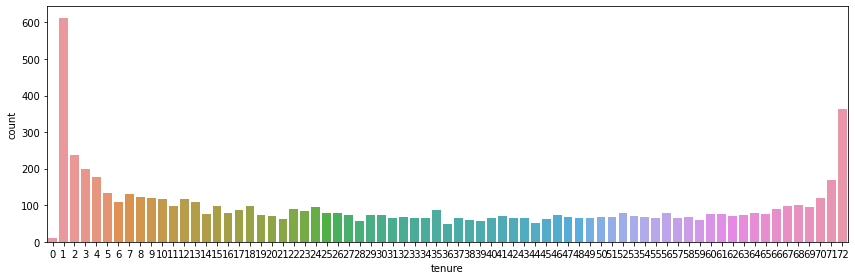

In [ ]:
fig, ax = plt.subplots(figsize=(12, 4))
sns.countplot(df['tenure'])
plt.tight_layout()

## Preparando dados para o modelo

> Aqui vamos substiuir todos os dados que irão passar pelo modelo por números, assim esse poderá interprertar os dados e trazer algumas previsões para o usuário.


In [ ]:
# pré processar as variáveis
binary_var = df_clean.nunique()[df_clean.nunique() == 2].keys().tolist()
num_var = [col for col in df_clean.select_dtypes(['int', 'float']).columns.tolist() if col not in binary_var]
cat_var = [col for col in df_clean.columns.tolist() if col not in binary_var + num_var]

# criar uma cópia do dataframe
df_proc = df_clean.copy()

# Label Encoding para as variáveis Binárias
le = LabelEncoder()
for i in binary_var:
    df_proc[i] = le.fit_transform(df_proc[i])

# Encoding para colunas categóricas com múltiplas classes
df_proc = pd.get_dummies(df_proc, columns=cat_var)

# ver as 5 primeiras entradas do novo dataframe
df_proc.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,PaperlessBilling,MonthlyCharges,TotalCharges,Churn,MultipleLines_No,MultipleLines_No phone service,MultipleLines_Yes,InternetService_DSL,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,0,1,0,1,0,1,29.85,29.85,0,0,1,0,1,0,0,1,0,0,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0
1,1,0,0,0,34,1,0,56.95,1889.50,0,1,0,0,1,0,0,0,0,1,1,0,0,0,0,1,1,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1
2,1,0,0,0,2,1,1,53.85,108.15,1,1,0,0,1,0,0,0,0,1,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,1
3,1,0,0,0,45,0,0,42.30,1840.75,0,0,1,0,1,0,0,0,0,1,1,0,0,0,0,1,0,0,1,1,0,0,1,0,0,0,1,0,1,0,0,0
4,0,0,0,0,2,1,1,70.70,151.65,1,1,0,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0


## Modelo de ML

> Uma vez que os dados estão tratados podemos agora iniciar os trabalhos na criação do modelo. A primeira coisa a ser feita é separar os dados em conjuntos de teste e de treino.

In [ ]:
# separar a feature matrix da target vector
X = df_proc.drop('Churn', axis=1)
y = df_proc['Churn']

# dividir os dados entre treino e teste.
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [ ]:
    """
    Realiza cross-validation com os dados de treino para determinado modelo.

    # Arguments
        X: DataFrame, contém as variáveis independetes.
        y: Series, vetor contendo a variável alvo.
        clf: modelo classificador do Scikit-learn.
        quite: bool, indicando se a função deve imprimir os resultados ou não.

    # Returns
        float, média dos scores da cross-validation.
    """

def val_model(X, y, clf, quite=False):
    
    X = np.array(X)
    y = np.array(y)

    pipeline = make_pipeline(StandardScaler(), clf)
    scores = cross_val_score(pipeline, X, y, scoring='f1')

    if quite == False:
        print("f1_score: {:.2f} (+/- {:.2f})".format(scores.mean(), scores.std()))
    
    return scores.mean()

> Nesta etapa vamos normalizar os dados de forma que a previsão do modelo fique mais acertivo.

*  **IMPORTANTE:** Somente os dados de treino devem ser normalizados, para que seja mais efetivo o treinamento do modelo. Os dados de teste devem permanecer desafiadores como os dados do dia a dia.

In [ ]:
#  padronizar os  dados,
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)

rus = RandomUnderSampler()
X_train_rus, y_train_rus = rus.fit_sample(X_train, y_train)

> Nesta etapa vamos descobrir quais são os melhores valores dos hiperparametros do modelo de XGBoost(modelo que vamos utilizar), vamos adotar a estratégia de buscar um paramentro por vez, assim não vamos sobre carregar a máquina.

**Hiperparamentros**

* learning_rate
* n_estimators
* max_depth 
* min_child_weight
* gamma

In [ ]:
xgb = XGBClassifier(learning_rate=0.1)

param_grid = {
 'n_estimators':range(0,1000,50),
}

# identificar melhor parâmetro
kfold = StratifiedKFold(n_splits=10, shuffle=True)
grid_search = GridSearchCV(xgb, param_grid, scoring='f1', n_jobs=-1, cv=kfold)
grid_result = grid_search.fit(X_train_rus, y_train_rus)

# ver resultados
print("Melhor: {} para {}".format(grid_result.best_score_, grid_result.best_params_))

Melhor: 0.7710962994196529 para {'n_estimators': 50}


In [ ]:
xgb = XGBClassifier(learning_rate=0.1, n_estimators=50)

param_grid = {
 'max_depth':range(1,8,1),
 'min_child_weight':range(1,5,1)
}

# identificar melhor parâmetro
kfold = StratifiedKFold(n_splits=10, shuffle=True)
grid_search = GridSearchCV(xgb, param_grid, scoring="f1", n_jobs=-1, cv=kfold)
grid_result = grid_search.fit(X_train_rus, y_train_rus)

# ver resultados
print("Melhor: {} para {}".format(grid_result.best_score_, grid_result.best_params_))

Melhor: 0.7731138146082782 para {'max_depth': 3, 'min_child_weight': 3}


In [ ]:
xgb = XGBClassifier(learning_rate=0.1, n_estimators=50, max_depth=3, min_child_weight=3)

param_grid = {
 'gamma':[i/10.0 for i in range(0,5)]
}

# identificar melhor parâmetro
kfold = StratifiedKFold(n_splits=10, shuffle=True)
grid_search = GridSearchCV(xgb, param_grid, scoring="f1", n_jobs=-1, cv=kfold)
grid_result = grid_search.fit(X_train_rus, y_train_rus)

# ver resultados
print("Melhor: {} para {}".format(grid_result.best_score_, grid_result.best_params_))

Melhor: 0.775232032737173 para {'gamma': 0.0}


In [ ]:
xgb = XGBClassifier(n_estimators=50, max_depth=1, min_child_weight=1, gamma=0.0)

param_grid = {
 'learning_rate':[0.001, 0.01, 0.1, 1]
}

# identificar melhor parâmetro
kfold = StratifiedKFold(n_splits=10, shuffle=True)
grid_search = GridSearchCV(xgb, param_grid, scoring="recall", n_jobs=-1, cv=kfold)
grid_result = grid_search.fit(X_train_rus, y_train_rus)

# ver resultados
print("Melhor: {} para {}".format(grid_result.best_score_, grid_result.best_params_))

Melhor: 0.8812949640287769 para {'learning_rate': 0.001}


> Dessa maneira atingimos o modelo final com os seguintes hiperparamentro e valores:

> **xgb = XGBClassifier(learning_rate=0.001 , n_estimators=50, max_depth=3, min_child_weight=3, gamma=0.0)**

              precision    recall  f1-score   support

           0       0.91      0.73      0.81      1282
           1       0.53      0.81      0.64       479

    accuracy                           0.75      1761
   macro avg       0.72      0.77      0.72      1761
weighted avg       0.81      0.75      0.76      1761

AUC: 0.7697



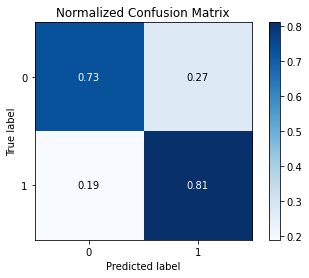

In [ ]:
# modelo final
xgb = XGBClassifier(learning_rate=0.001 , n_estimators=50, max_depth=3, min_child_weight=3, gamma=0.0)
xgb.fit(X_train_rus, y_train_rus)

# fazer a previsão
X_test = scaler.transform(X_test)
y_pred = xgb.predict(X_test)

# Classification Report
print(classification_report(y_test, y_pred))

# imprimir a área sob a curva
print("AUC: {:.4f}\n".format(roc_auc_score(y_test, y_pred)))

# plotar matriz de confusão
plot_confusion_matrix(y_test, y_pred, normalize=True)
plt.show()

## Conclusão

> O modelo de teve um desempenho razoável, ainda existem algumas melhorias que podem ser feitas com relações as dados, podendo tornar algumas colunas binárias ao invés de ter 3 ou mais entradas possíveis.

> O modelo deve um acerto de 81% nos clientes que iriam deixar de usar o serviço e 73% de acerto nos clientes que continuariam a usar o produto

> Convido o leitor a ultilizar os dados aqui usados e tentar melhorar o modelo e enriquecer a análise exploratória.